In [1]:
import numpy as np
from scipy.linalg import khatri_rao
from submit import get_renamed_labels, get_features
import time as tm
import matplotlib.pyplot as plt

In [2]:
train_data = np.loadtxt('train.dat')
X_train = train_data[:,:-1]
y_train = train_data[:,-1]

test_data = np.loadtxt('test.dat')
X_test = test_data[:,:-1]
y_test = test_data[:,-1]

X_train.shape, y_train.shape

((10000, 8), (10000,))

In [3]:
X_train = get_features(X_train)
y_train = get_renamed_labels(y_train)

X_test = get_features(X_test)
y_test = get_renamed_labels(y_test)

X_train.shape, y_test.shape

((10000, 729), (20000,))

In [5]:
y_train = y_train.astype('int')

In [6]:
def stepLengthGenerator( mode, eta ):
	if mode == "constant":
		return lambda t: eta
	elif mode == "linear":
		return lambda t: eta/(t+1)
	elif mode == "quadratic":
		return lambda t: eta/np.sqrt(t+1)

class SVM:
    def __init__(self, X, y, C):
        self.X = X.copy()
        self.y = y.copy()
        self.C = C
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.__intialize_params__()

    def __intialize_params__(self):
        X = self.X
        y = self.y

		# param intiliaziation for SDCM
		
        initDual = self.C * np.ones((self.n))
        self.normSq = np.square( np.linalg.norm( X, axis = 1 ) ) + 1
        self.w_SDCM = X.T.dot( np.multiply( initDual, y ) )
        self.alpha = initDual

		# param init for GD
        self.theta = np.zeros((self.d))
    
    def predict(self, X):

        y_new = X.dot(self.w_SDCM) 
        return y_new

    def doCoordOptCSVMDual(self, i ):
        x = self.X[i,:]
        y = self.y
        w_SDCM = self.w_SDCM
        C = self.C

        # Find the unconstrained new optimal value of alpha_i
        # It takes only O(d) time to do so because of our clever book keeping
        newAlphai = (1 - y[i] * x.dot(w_SDCM) ) / self.normSq[i]
        
        # Make sure that the constraints are satisfied. This takes only O(1) time
        if newAlphai > C:
            newAlphai = C
        if newAlphai < 0:
            newAlphai = 0

        # Update the primal model vector and bias values to ensure bookkeeping is proper
        # Doing these bookkeeping updates also takes only O(d) time
        self.w_SDCM = w_SDCM + (newAlphai - self.alpha[i]) * y[i] * x
        
        return newAlphai

    def getCSVMPrimalDualObjVals( self ):
        w_SDCM = self.w_SDCM
        X = self.X
        y = self.y
        C = self.C

        hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w_SDCM )), y ), 0 )
        objPrimal = 0.5 * w_SDCM.dot( w_SDCM ) + C * np.sum(hingeLoss)
        # Recall that b is supposed to be treated as the last coordinate of w
        objDual = np.sum( self.alpha ) - 0.5 * np.square( np.linalg.norm( w_SDCM ) )
        
        return np.array( [objPrimal, objDual] )

    def getRandpermCoord( self, state ):
        idx = state[0]
        perm = state[1]
        d = len( perm )
        if idx >= d - 1 or idx < 0:
            idx = 0
            perm = np.random.permutation( d )
        else:
            idx += 1
        state = (idx, perm)
        curr = perm[idx]
        return (curr, state)
    
    def doSDCM(self, horizon = 10 ):
        objValSeries = []
        timeSeries = []
        totTime = 0
        d = self.d
        state = (-1,np.random.permutation( d ))
        # Initialize model as well as some bookkeeping variables
        
        for it in range( horizon ):
            # Start a stopwatch to calculate how much time we are spending
            tic = tm.perf_counter()
            
            # Get the next coordinate to update and update that coordinate
            (i, state) = self.getRandpermCoord( state )
            (self.alpha)[i] = self.doCoordOptCSVMDual(  i)

            toc = tm.perf_counter()
            totTime = totTime + (toc - tic)
            # print('\r Accuracy:', self.eval(self.X, self.y), end='')
            objValSeries.append( self.getCSVMPrimalDualObjVals() )
            timeSeries.append( totTime )
            
        return (objValSeries, timeSeries)

    def getCSVMGrad(self, theta ):
        y = self.y
        C = self.C
        X = self.X

        w = theta
        discriminant = np.multiply( (X.dot( w )), y )
        g = np.zeros( (y.size,) )
        g[discriminant < 1] = -1
        # delb = C * g.dot( y )
        delw = w + C * (X.T * g).dot( y )
        return delw

    def getCSVMObjVal(self,  theta ):
        C = self.C
        X = self.X
        y = self.y

        w = theta
        hingeLoss = np.maximum( 1 - np.multiply( (X.dot( w )), y ), 0 )
        return 0.5 * w.dot( w ) + C * np.sum( hingeLoss )
    
    def clean_up(self, cumulative, doModelAveraging, it ):
        final = 0
        if doModelAveraging:
            final = cumulative / (it + 1)
        else:
            final = cumulative
        
        self.theta = final
        self.w_SDCM = final
	
    def doGD( self, stepFunc , doModelAveraging, spacing, timeout):
        objValSeries = []
        timeSeries = []
        totTime = 0
        theta = self.theta
        cumulative = self.theta
        it = 1
        
        while True:
            # Start a stopwatch to calculate how much time we are spending
            tic = tm.perf_counter()
            delta = self.getCSVMGrad( theta )
            theta = theta - stepFunc( it + 1 ) * delta
            # If we are going to do model averaging, just keep adding the models
            if doModelAveraging:
                cumulative = cumulative + theta
            else:
                cumulative = theta
            # All calculations done -- stop the stopwatch
            toc = tm.perf_counter()
            totTime = totTime + (toc - tic)
            # If model averaging is being done, need to calculate current objective value a bit differently
            if doModelAveraging:
                objValSeries.append( self.getCSVMObjVal( cumulative/(it+2) ) )
            else:
                objValSeries.append( self.getCSVMObjVal( cumulative ) )

            timeSeries.append( totTime )
            
            if it%spacing ==0 and totTime > timeout:
                self.clean_up(cumulative, doModelAveraging, it)
                return (objValSeries, timeSeries)
            it+=1


    def eval(self, X_t, y_t):
        y_t_pred = self.predict( X_t )
        y_t_pred = np.where( y_t_pred > 0, 1, -1 )
        acc = np.average( y_t == y_t_pred )
        return acc



In [7]:

svm_classifier = SVM(X_train, y_train, C=5.0)

In [8]:
C = 1
eta = 1
hist_gd = svm_classifier.doGD(stepLengthGenerator('linear', eta), doModelAveraging=True, spacing = 10, timeout=5) 

In [9]:
# history = svm_classifier.doSDCM(horizon=10000)

In [10]:
svm_classifier.eval(X_test, y_test)

0.9367

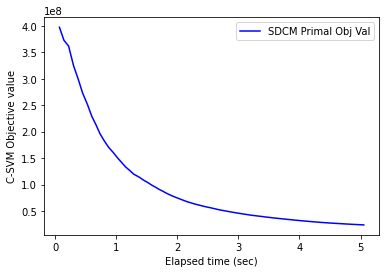

In [11]:
# fig1 = pd.getFigure( 7, 7 )
# plt.figure( fig1.number )
obj_SDCM = hist_gd[0]
time_SDCM = hist_gd[1]
primal_SDCM = [obj_SDCM[i] for i in range(len(obj_SDCM))]
# dual_SDCM = [obj_SDCM[i] for i in range(len(obj_SDCM))]
plt.plot( time_SDCM, primal_SDCM, color = 'b', linestyle = '-', label = "SDCM Primal Obj Val" )
# plt.plot( time_SDCM, dual_SDCM, color = 'b', linestyle = ':', label = "SDCM Dual Obj Val" )
plt.legend()
plt.xlabel( "Elapsed time (sec)" )
plt.ylabel( "C-SVM Objective value" )

# plt.ylim( np.median( dual_SDCM ), np.median( primal_SDCM ) )

plt.show()

In [18]:
def eval(theta, X_t, y_t):
        y_t_pred = X_t.dot(theta)
        y_t_pred = np.where( y_t_pred > 0, 1, -1 )
        acc = np.average( y_t == y_t_pred )
        return acc

def stepLengthGenerator( mode, eta ):
	if mode == "constant":
		return lambda t: eta
	elif mode == "linear":
		return lambda t: eta/(t+1)
	elif mode == "quadratic":
		return lambda t: eta/np.sqrt(t+1)

def solver( X, y, timeout, spacing, X_test, y_test ):

	(n, d) = X.shape
	t = 0
	totTime = 0
	W = []
	B = 0
	tic = tm.perf_counter()

	theta = np.zeros(d)
	
	C=5.0
	
	
	def getCSVMObjVal( theta ):
		w = theta
		hingeLoss = np.maximum( 0, 1 - y * ( np.dot( X, w ) ) )
		return 0.5 * np.dot( w, w ) + C * np.sum( hingeLoss )

	def getCSVMGrad( theta ):
		w = theta	
		discriminant = y * ( np.dot( X, w ) )
		g = np.zeros( (y.size,))
		g[discriminant < 1] = -1
		delw = w + C * np.dot( X.T * g, y )
		return delw

	# def clean_up(cumulative, doModelAveraging, it):
	# 	final = 0
	# 	if doModelAveraging:
	# 		final = cumulative/(it+1)
	# 	else:
	# 		final = cumulative
	# 	theta=final
	
	objValSeries = []
	timeSeries = []
	cumulative = theta
	acc = []
	updater = stepLengthGenerator( "linear", 1 )
	while True:
		t = t + 1
		if t % spacing == 0:
			acc_new = eval(theta, X_test, y_test)
			acc.append(acc_new)
			toc = tm.perf_counter()
			totTime = totTime + (toc - tic)
			if totTime > timeout:
				W = theta
				B = 0
				return ( W.reshape( ( W.size, ) ), B, totTime, acc )			# Reshape W as a vector
			else:
				tic = tm.perf_counter()
		delta = getCSVMGrad( theta )
		theta = theta - updater( t + 1 ) * delta
		cumulative = cumulative + theta
		objValSeries.append( getCSVMObjVal( cumulative/(t+2) ) )
		timeSeries.append( totTime )

	
		
	return ( W.reshape( ( W.size, ) ), B, totTime )

In [24]:
history = solver(X_train, y_train, 5, 1, X_test, y_test)

In [17]:
theta = history[0]
acc = eval(theta, X_test, y_test)
print(acc)

1.0


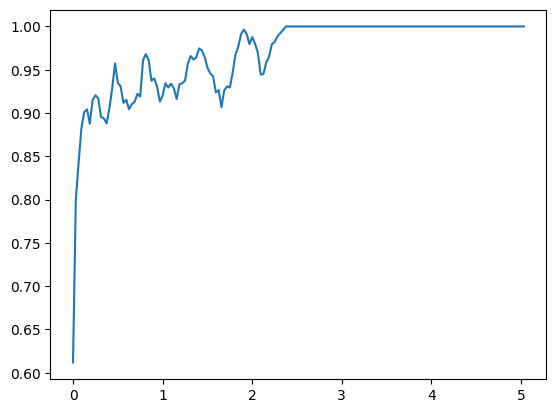

In [25]:
plt.plot(np.linspace(0,history[2], len(history[3])), history[3])